In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

import utils
import forward_model
import globals
import nesterov
import section_search
import coordinate_descent
import dataset_loader
import initialization

import torch

/data/holly_jackson/dfd-sparse-uv/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


Df: [ 1.  2.  4.  8. 16. 32. 64.]
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 3.2
Aperture diameter (m): 0.002216796875
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 4.08 - 80.0


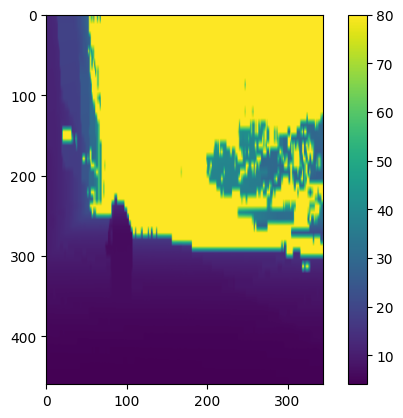

adaptive kernel size set to 17
1.5456521739130434e-07


In [2]:
globals.init_Make3D()

IMAGE_RANGE = 255.
gt_aif, gt_dpt = dataset_loader.load_single_sample_Make3D(img_name='img-060705-17.10.14-p-018t000.jpg', data_dir = "/data/holly_jackson/")
gt_aif = gt_aif * IMAGE_RANGE


gt_dpt_resized = skimage.transform.resize(
    gt_dpt,
    output_shape=(460, 345), # (height, width)
    order=1,                  # bilinear interpolation
    anti_aliasing=True,
    preserve_range=True       # keep values in [0, 255] if original was uint8
)

plt.imshow(gt_dpt_resized)
plt.colorbar()
plt.show()

width, height, _ = gt_aif.shape
max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

globals.thresh = 0.5
globals.ps *= 0.01
print(globals.ps)
# globals.Df = np.array([0.5, 1, 2, 4, 8, 16, 24, 32, 48, 64, 72], dtype=np.float32)


precomputing indices


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.032234844..1.0000008].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.040807728..1.0000006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03336455..1.0000006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.025699861..1.0000006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030004935..1.0000006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02781869..1.0000005].


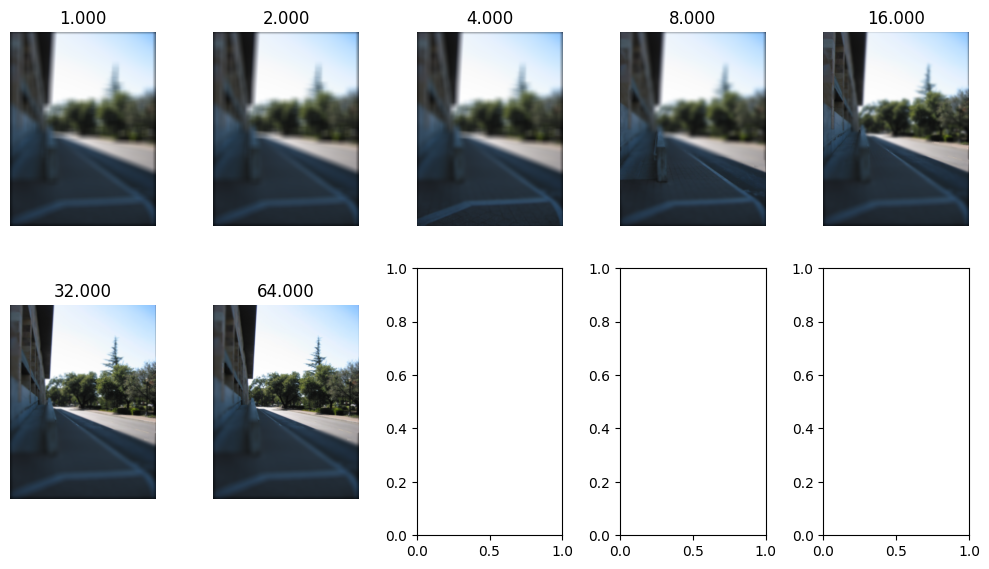

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030004919..1.0000001].


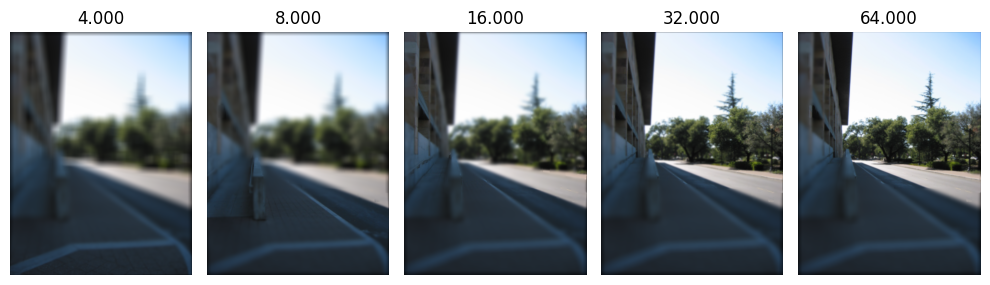

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030004919..1.0000001].


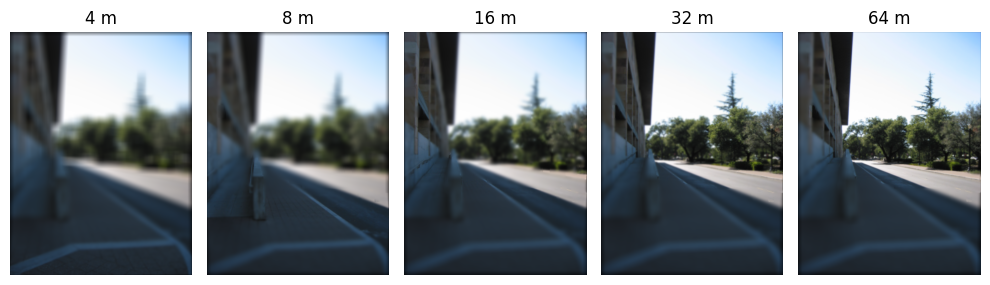

In [3]:
# forward model (torch)
# FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt_resized, gt_aif)
# defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

utils.plot_single_stack(defocus_stack[2:] / IMAGE_RANGE, globals.Df[2:])

import math
recon = defocus_stack[2:] / IMAGE_RANGE
setting = globals.Df[2:]
recon_max = None

num_images = len(recon)
cols = 5
rows = math.ceil(len(recon) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 3))
if rows == 1:
    axes = np.array([axes])  # make it a list for consistency
axes = axes.flatten()

for i in range(num_images):
    if recon_max is None:
        recon_max = recon[i].max()
    axes[i].imshow(recon[i] / recon_max)
    axes[i].axis('off')
    axes[i].set_title(f"{setting[i]:.0f} m")

# if title:
#     fig.suptitle(title)

plt.tight_layout()
plt.savefig("focal_stack_example.png", dpi=800, bbox_inches="tight", pad_inches=0)
plt.show()

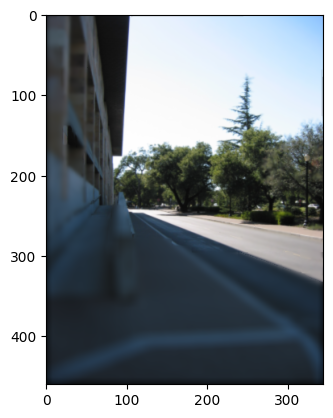

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.032234825..1.0000002].


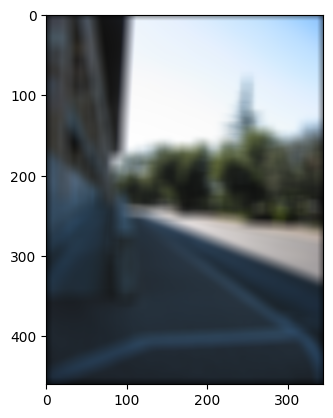

In [4]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

Depth range: [ 0.01 - 80 ]
Created experiment folder: /data/holly_jackson/experiments/make3d_2026-02-09_17-33-10
Images in range [0-255]
precomputing indices


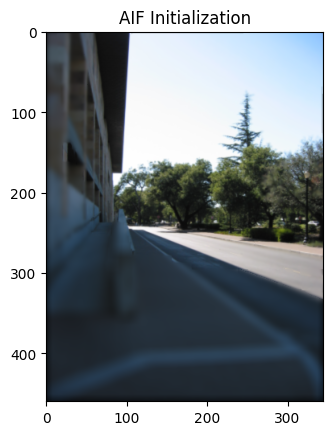

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [01:32<00:00,  1.09it/s]


GRID SEARCH DURATION 92.2165174484253


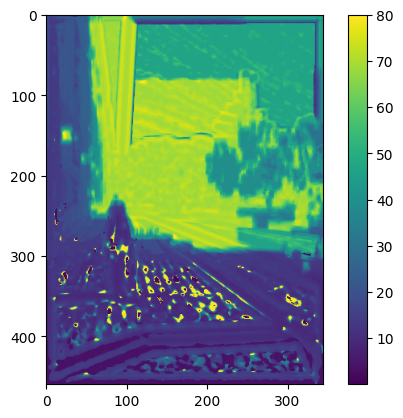


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 145.50136518478394


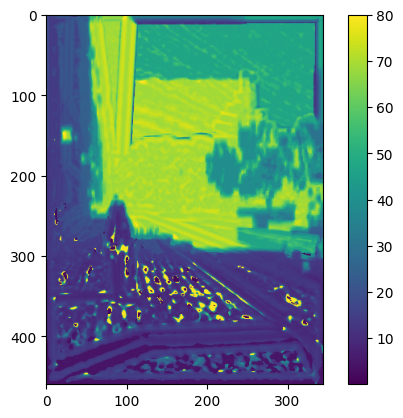

Loss: 10.596327 , TV: 567248.75

DPT result range: [ 0.013284686 , 79.99672 ]


Bounded FISTA...


Optimizing: 100%|████████████████████████████████████████████| 10/10 [00:31<00:00,  3.10s/it]


r1norm 2378.4436 norm(x) 93128.72
FISTA duration 56.19497513771057

AIF result range: [ 6.6745577 , 255.0 ]
Loss: 1.6685588 , TV: 3440985.5


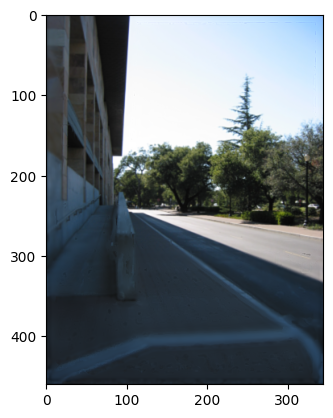

FULL ITER DURATION 306.2803359031677
T_i updated to 20


--------------------------

Iteration 1 



Grid search         : 100%|███████████████████| 100/100 [01:31<00:00,  1.09it/s]


GRID SEARCH DURATION 91.982901096344


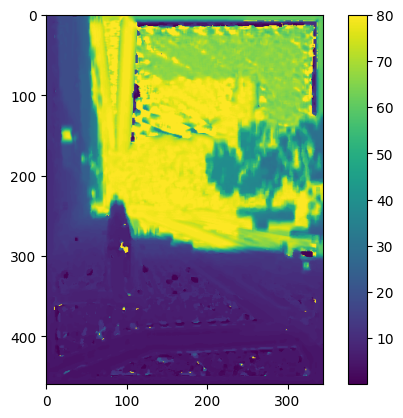


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 149.66295289993286


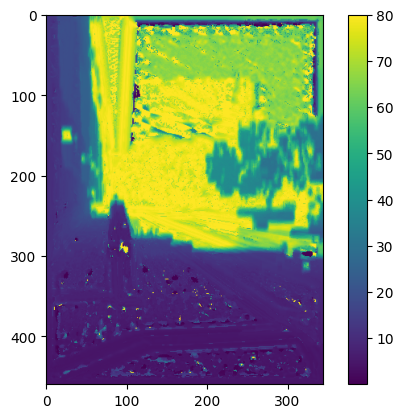

Loss: 0.68849665 , TV: 614247.0

DPT result range: [ 0.013284686 , 79.99672 ]


Bounded FISTA...


Optimizing: 100%|████████████████████████████████████████████| 20/20 [00:57<00:00,  2.86s/it]


r1norm 867.4714 norm(x) 93250.58
FISTA duration 80.53594470024109

AIF result range: [ 6.846257 , 255.0 ]
Loss: 0.22454154 , TV: 3787051.0


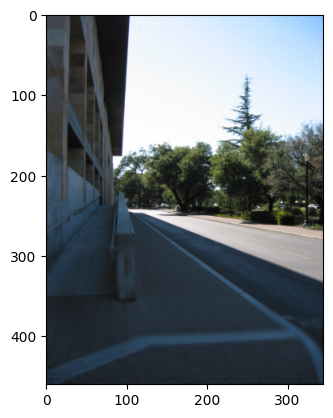

FULL ITER DURATION 334.17368745803833
T_i updated to 40


--------------------------

Iteration 2 



Grid search         : 100%|███████████████████| 100/100 [01:32<00:00,  1.09it/s]


GRID SEARCH DURATION 92.227543592453


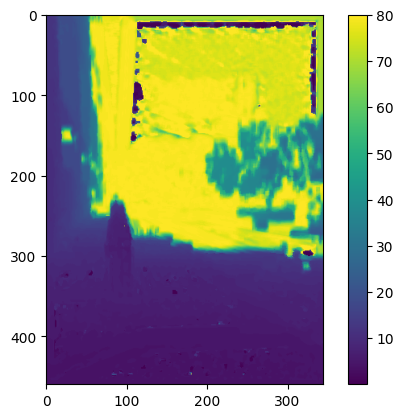


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 149.67401146888733


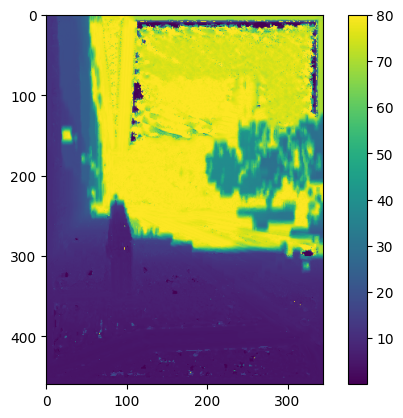

Loss: 0.12812768 , TV: 445282.7

DPT result range: [ 0.013284686 , 79.99672 ]


Bounded FISTA...


Optimizing: 100%|████████████████████████████████████████████| 40/40 [01:51<00:00,  2.80s/it]


r1norm 529.05536 norm(x) 93278.02
FISTA duration 134.42799925804138

AIF result range: [ 6.8890104 , 255.0 ]
Loss: 0.08394542 , TV: 3782394.5


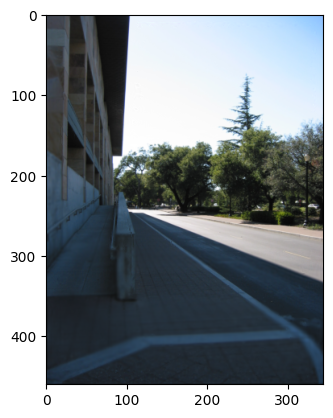

FULL ITER DURATION 388.3607368469238
T_i updated to 80


--------------------------

Iteration 3 



Grid search         : 100%|███████████████████| 100/100 [01:32<00:00,  1.09it/s]


GRID SEARCH DURATION 92.20899605751038


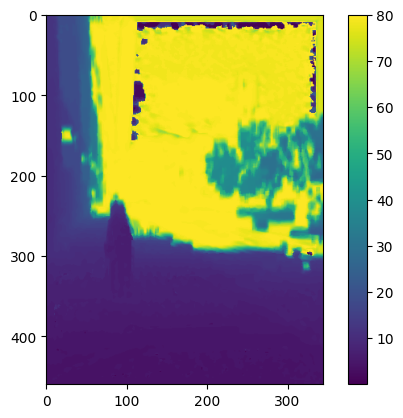


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 148.9038052558899


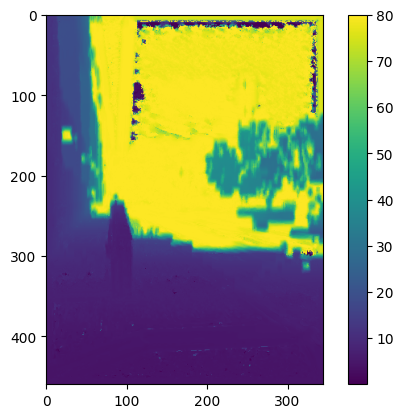

Loss: 0.06823509 , TV: 373064.84

DPT result range: [ 0.013284686 , 79.99672 ]


Bounded FISTA...


Optimizing: 100%|████████████████████████████████████████████| 80/80 [03:44<00:00,  2.80s/it]


r1norm 446.882 norm(x) 93291.9
FISTA duration 246.61611461639404

AIF result range: [ 6.874251 , 255.0 ]
Loss: 0.059923004 , TV: 3856881.0


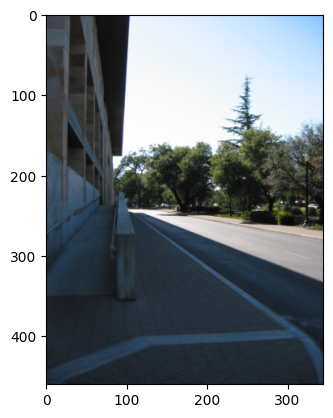

FULL ITER DURATION 499.55460476875305
T_i updated to 160


--------------------------

Iteration 4 



Grid search         : 100%|███████████████████| 100/100 [01:31<00:00,  1.09it/s]


GRID SEARCH DURATION 91.86978268623352


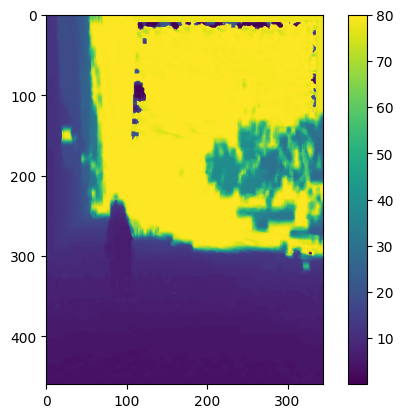


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 151.22164964675903


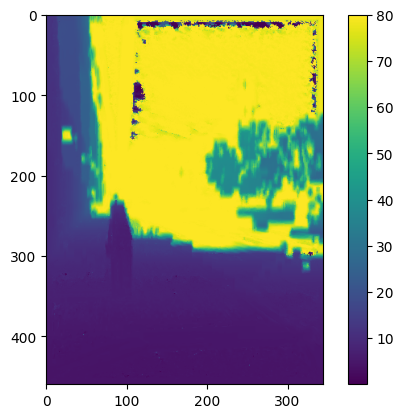

Loss: 0.0562369 , TV: 330251.8

DPT result range: [ 0.01985406 , 79.99672 ]


Bounded FISTA...


Optimizing: 100%|██████████████████████████████████████████| 160/160 [07:37<00:00,  2.86s/it]


r1norm 424.3508 norm(x) 93299.22
FISTA duration 479.8444664478302

AIF result range: [ 6.884736 , 255.0 ]
Loss: 0.05403401 , TV: 3953718.0


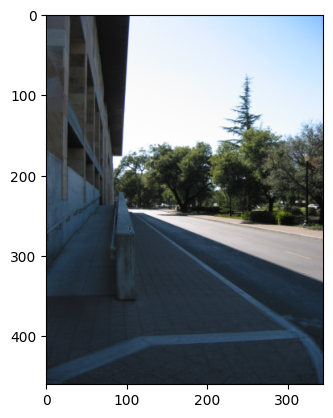

FULL ITER DURATION 734.9927537441254
T_i updated to 320


--------------------------



In [5]:
# -------------------
# COORDINATE DESCENT
# -------------------

globals.window_size = 5
# depth_init = 40

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=True, save_plots=False,
        experiment_name = 'make3d', num_epochs = 5,
        # least_squares_first=True, depth_init=depth_init,
        nesterov_first=False, aif_init = aif_init,                                             
        # k = 1, aif_method = 'fista',
        num_Z = 100, 
        T_0 = 10, alpha = 2, 
        # min_Z = globals.min_Z, max_Z = globals.max_Z,
        # vmin = globals.min_Z, vmax = globals.max_Z,
                                                       verbose = True,
        windowed_mse = True)


In [ ]:
# experiment_folder = '/data/holly_jackson/experiments/make3d_2025-11-06_00-12-20'
# utils.save_dpt_npy(experiment_folder, 'dpt', dpt)
# utils.save_aif(experiment_folder, 'aif', aif)
# dpt_loaded = utils.load_dpt_npy(experiment_folder, 'dpt')
# aif_loaded = utils.load_aif(experiment_folder, 'aif')
# assert np.array_equal(dpt, dpt_loaded)
# assert np.array_equal(aif, aif_loaded)


In [ ]:
print('RMS', utils.compute_RMS(dpt, gt_dpt_resized))
print('Rel', utils.compute_Rel(dpt, gt_dpt_resized))
print(utils.compute_accuracy_metrics(dpt, gt_dpt_resized))

utils.plot_compare_greyscale(dpt, gt_dpt_resized, vmin=globals.min_Z, vmax=globals.max_Z)


# todo: fista check if A @ x is quicker stacked or in loop

In [ ]:
worst_coords = utils.get_worst_diff_pixels(dpt, gt_dpt_resized, num_worst_pixels=10, vmin=gt_dpt.min(), vmax=gt_dpt.max())

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - gt_dpt_resized)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [ ]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = globals.min_Z, max_Z = globals.max_Z, num_Z = 100, k = 1)

print(k_min_indices.shape)

In [ ]:
dpt = np.array([[globals.min_Z]], dtype=np.float32)
r = forward_model.computer(dpt, globals.Df)[...,None,None]
# print(r)

print(globals.Df, globals.D, globals.f)
Df_expanded = globals.Df.reshape(1, 1, -1)
CoC = ((globals.D) 
        * (np.abs(dpt[...,None] - Df_expanded) / (dpt[...,None]+1e-8)) 
        * (globals.f / np.abs(Df_expanded - globals.f)))
r = CoC / 2. / globals.ps
print(CoC)
print(r)

In [ ]:
i, j = 100, 100
utils.plot_grid_search_on_pixel(i, j, Z, all_losses,
                                k_min_indices=k_min_indices[i,j])

In [ ]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt_resized,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt_resized,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])